# IrisのデータをXGBoostで解析してみる。クラス分類。

In [1]:
# https://ensekitt.hatenablog.com/entry/2018/02/17/200000

In [2]:
# 学習関連
import xgboost as xgb
from sklearn import model_selection
# 評価関連
from sklearn.metrics import confusion_matrix, classification_report

# データセット
from sklearn import datasets

# データを扱うため
import pandas as pd
import numpy as np

# 可視化関連
import matplotlib.pyplot as plt
import graphviz

In [3]:
iris = datasets.load_iris()
# これだけで読み込んでくれる
iris_df = pd.DataFrame(iris.data)
iris_df = iris_df.rename(columns={
    0: 'sepal_length',
    1: 'sepal_width',
    2: 'petal_length',
    3: 'petal_width'})
iris_df['target'] = iris.target
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# データセットを学習用と評価用に分ける

In [4]:
train_df, test_df = model_selection.train_test_split(iris_df, test_size=0.3) # 30%をテストに使う
train_df_y = train_df[['target']] #target column only for y
train_df_x = train_df.copy().drop('target', axis=1) #copy and drop target for x do need copy 
# same for tests
test_df_y = test_df[['target']]
test_df_x = test_df.copy().drop('target', axis=1)

# ハイパーパラメータ検索

# 2.ハイパーパラメータ探索しつつ学習する

In [5]:
# 今回はアヤメの種類を当てるクラス分類なのでXGBClassifier
clf = xgb.XGBClassifier()

In [6]:
# ハイパーパラメータ探索

clf_cv = model_selection.GridSearchCV(estimator = clf,param_grid ={'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_cv.fit(train_df_x, [i[0] for i in train_df_y.values])
print('clf_cv.best_params_★{} ,\nclf_cv.best_score_★{}'.format(clf_cv.best_params_, clf_cv.best_score_))



/Users/s.okubo/Documents/Projects/python_venvs/py3_6_8/.venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
clf_cv.best_params_★{'max_depth': 2, 'n_estimators': 50} ,
clf_cv.best_score_★0.9714285714285714


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.7s finished
/Users/s.okubo/Documents/Projects/python_venvs/py3_6_8/.venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
# 良さげなパラメータで学習しなおす
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(train_df_x, [i[0] for i in train_df_y.values])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# 評価する

In [13]:
print("confusion matrix:")
pred = clf.predict(test_df_x)
print(confusion_matrix([i[0] for i in test_df_y.values], pred))
print(classification_report([i[0] for i in test_df_y.values], pred))

confusion matrix:
[[12  0  0]
 [ 0 17  2]
 [ 0  0 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94        19
           2       0.88      1.00      0.93        14

   micro avg       0.96      0.96      0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



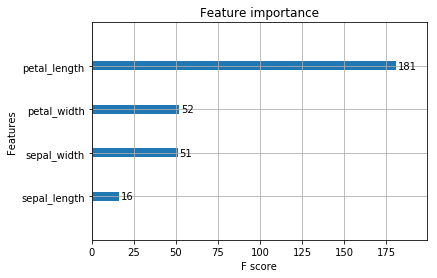

In [14]:
xgb.plot_importance(clf)
plt.show()

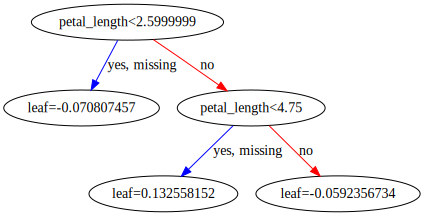

In [15]:
xgb.to_graphviz(clf, num_trees=1)